## Задание для VK  стажировки в отделе бизнеса и рекламы (2019 г.)

### Задачи:

1. Воспроизвести график рекламных событий по дням, который отражает резкий скачок числа событий за 11 апреля.

<img src="event_distribution.jpeg">

2. Найдите причину резкого увеличения количества рекламных событий и объясните, что произошло.

3. Предложите способ, который помог бы автоматически детектировать аномальные изменения метрик на графиках рекламной статистики. Иными словами, предложите алгоритм, который каждое утро анализирует данные за прошедшие сутки, и, если они сильно выбиваются из общего тренда, отправляет аналитику уведомление: на этом графике есть проблема за вчерашний день. Подумайте, как сделать детектор, который проверяет на аномалии каждый час, каждые пять минут в графике? Предложите вариант кода, который решает эту задачу. Реализовывать логику нотификации не нужно, только поиск аномального дня, часа, пятиминутки в данных рекламной статистики 


### Описание [данных](https://vk.com/away.php?to=https%3A%2F%2Fvk.cc%2F9jp172):

* **time** — время взаимодействия пользователя с рекламой в формате UnixTime;
* **event** — тип взаимодействия (click — клик на объявление, view — показ объявления, report — жалоба на объявление);
* **ad_cost_type** — тип трат рекламного объявления (CPM — траты за 1000 показов, CPC — траты за клик);
* **has_video** — наличие видео в объявлении (0 — нет, 1 — есть);
* **agency_union_id** — id рекламного агентства (если рекламный кабинет принадлежит физическому лицу, то ячейка будет заполнена значением 'no_agency');
* **client_union_id** — id рекламного клиента;
* **campaign_union_id** — id рекламной кампании;
* **ad_id** — id рекламного объявления;
* **platform** — платформа, с которой пользователь взаимодействовал с рекламой (web — веб-версия, mvk — мобильная версия, iphone — IOS-приложение, android — Android-приложение, wphone — Windows Phone-приложение).


## Часть 1
Для начала скачаем, изучим данные и нарисуем график распределения событий по дням.

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import sparse, stats

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns

%config IPCompleter.greedy=True
%matplotlib inline

adv_events = pd.read_csv('adv_vk_test_data.csv', parse_dates=True, index_col='date')

adv_events.info()
adv_events.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 122097 entries, 2019-04-08 to 2019-04-08
Data columns (total 9 columns):
time                 122097 non-null float64
event                122097 non-null object
ad_cost_type         122097 non-null object
has_video            122097 non-null int64
agency_union_id      122097 non-null object
client_union_id      122097 non-null object
campaign_union_id    122097 non-null object
ad_id                122097 non-null object
platform             122097 non-null object
dtypes: float64(1), int64(1), object(7)
memory usage: 6.1+ MB


,time,event,ad_cost_type,has_video,agency_union_id,client_union_id,campaign_union_id,ad_id,platform
date,,,,,,,,,
2019-04-08,1.554744e+09,report,CPM,0,no_agency,client_21074,campaign_27489,ad_27489,android
2019-04-12,1.555103e+09,click,CPM,0,no_agency,client_22392,campaign_35893,ad_35893,android
2019-04-16,1.555403e+09,click,CPM,0,no_agency,client_16836,campaign_26799,ad_26804,web
2019-04-09,1.554822e+09,click,CPM,0,no_agency,client_22920,campaign_37146,ad_37146,android
2019-04-11,1.554967e+09,click,CPM,0,no_agency,client_645,campaign_15893,ad_15944,web


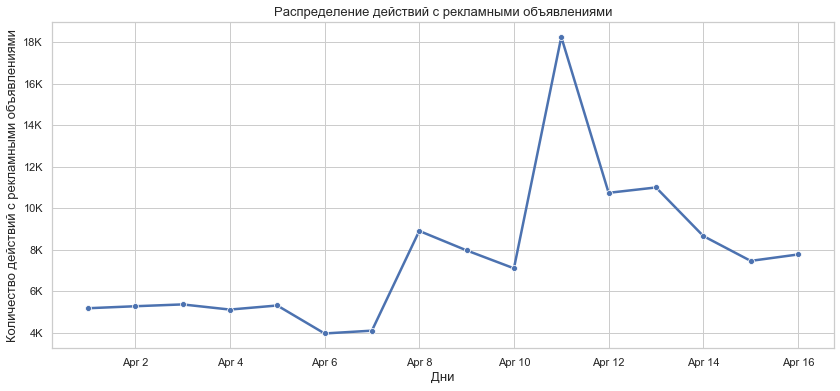

In [2]:
num_events_by_days = adv_events.groupby('date').event.count()
sns.set(rc={'figure.figsize':(14,6)})
sns.set(style="whitegrid")
curr_plot = sns.lineplot(style="event", data=num_events_by_days, marker="o", lw=2.5)             
curr_plot.figure.set_size_inches(14, 6)
curr_plot.set_title('Распределение действий с рекламными объявлениями', fontsize=13)
curr_plot.set_xlabel('Дни', fontsize=13)
curr_plot.set_ylabel('Количество действий с рекламными объявлениями', fontsize=13)

ylabels = ['{:,.0f}'.format(x) + 'K' for x in curr_plot.get_yticks()/1000]
curr_plot.set_yticklabels(ylabels)

curr_plot.xaxis.set_major_formatter(mdates.DateFormatter('%b %#d'))
curr_plot.xaxis.set_major_locator(mdates.DayLocator([x for x in range(32) if x % 2 == 0]) )


Действительно график отражает, что 11 апреля есть явный "всплеск", аномально высокое количество событий. При этом можно также отметить, что в целом начиная с 8-го числа присутствует увеличение числа событий, по сравнению с предыдущей неделей. 

Гипотеза, которая приходит на ум: вероятно, есть объявления, которые показывают гораздо чаще других.

## Часть 2

In [3]:
adv_events.nunique()

time                 113789
event                     3
ad_cost_type              2
has_video                 2
agency_union_id         351
client_union_id        8709
campaign_union_id     12330
ad_id                 18049
platform                  5
dtype: int64

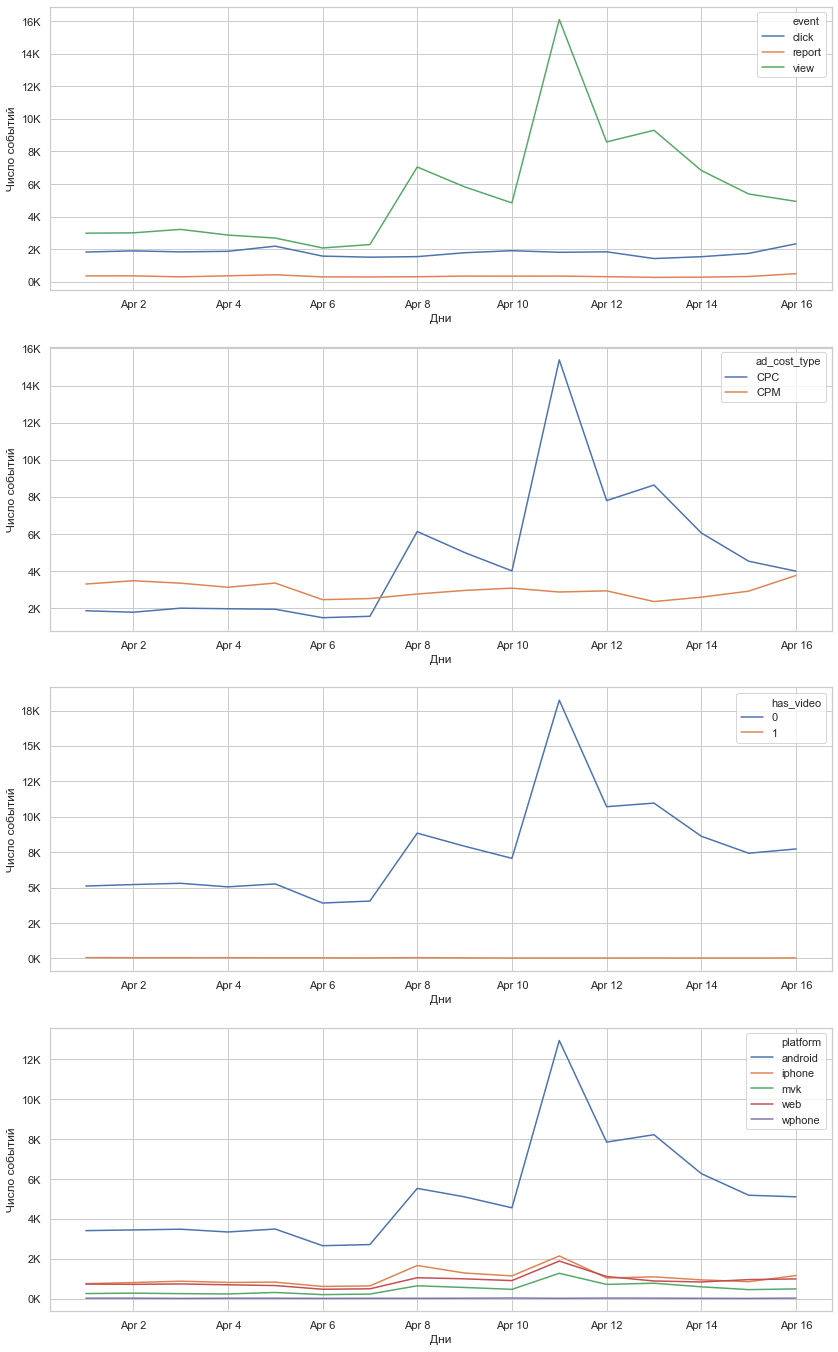

In [4]:
fig, axs = plt.subplots(4)
fig.set_size_inches(14, 24)
for index, col in enumerate(['event', 'ad_cost_type', 'has_video', 'platform']):
    plt_data = adv_events.groupby(['date', col]).agg({'time': 'count'}).reset_index()
    curr_plot = sns.lineplot(x="date", y="time", hue=col, ax=axs[index], data=plt_data)
    
    ylabels = ['{:,.0f}'.format(x) + 'K' for x in curr_plot.get_yticks()/1000]
    curr_plot.set_yticklabels(ylabels)
    curr_plot.set_ylabel("Число событий")
    curr_plot.set_xlabel("Дни")
    curr_plot.xaxis.set_major_formatter(mdates.DateFormatter('%b %#d'))
    curr_plot.xaxis.set_major_locator(mdates.DayLocator([x for x in range(32) if x % 2 == 0]) )

In [5]:
adv_events.has_video.value_counts() / len(adv_events)

0    0.994529
1    0.005471
Name: has_video, dtype: float64

Исходя из графиков, можно предположить что причиной роста явились события типа view с оплатой за клики. Вероятно, что эти события были по объявлениям без видео, но этот показатель не является существенным, т.к. в целом доля с событий с видео составляет около 0.5 процента, от общего числа событий. От платформы события вероятно не зависят, т.к. рост событий наблюдается на всех платформах, хотя на android рост более явно выражен.

##### Возможно данные события были сгенерированны одним объявлением?

In [6]:
adv_events['datetime'] = pd.to_datetime(adv_events.time, unit='s')
adv_events = adv_events.reset_index()
adv_events = adv_events.set_index('datetime')
adv_events = adv_events.sort_index()

print("Число уникальных объявлений: {}".format(adv_events.ad_id.nunique()))

Число уникальных объявлений: 18049


In [7]:
adv_events.groupby('ad_id').agg({'event':'count'}).describe()

,event
count,18049.000000
mean,6.764752
std,224.228418
min,1.000000
25%,1.000000
50%,1.000000
75%,3.000000
max,27500.000000


In [8]:
adv_events.groupby('ad_id').agg({'event':'count'}).sort_values('event', ascending=False).head(15)

,event
ad_id,
ad_49554,27500
ad_49556,8218
ad_49560,7496
ad_49564,4491
ad_47269,1867
ad_99643,577
ad_7701,559
ad_21831,491
ad_387,461


In [9]:
suspicious_ads = ['ad_49554', 'ad_49556', 'ad_49560', 'ad_49564', 'ad_47269']
for ad in suspicious_ads:
    curr_add = adv_events[adv_events.ad_id == ad].head(1)
    print("Объявление {} cостоит в рекламной кампании {},"\
           .format(curr_add.ad_id.iloc[0], curr_add.campaign_union_id.iloc[0]))
    print("которая принадлежит клиенту {} и рекламному агенству: {} \n"\
          .format(curr_add.client_union_id.iloc[0], curr_add.agency_union_id.iloc[0]))
           

Объявление ad_49554 cостоит в рекламной кампании campaign_49554,
которая принадлежит клиенту client_47270 и рекламному агенству: agency_2 

Объявление ad_49556 cостоит в рекламной кампании campaign_49554,
которая принадлежит клиенту client_47270 и рекламному агенству: agency_2 

Объявление ad_49560 cостоит в рекламной кампании campaign_49554,
которая принадлежит клиенту client_47270 и рекламному агенству: agency_2 

Объявление ad_49564 cостоит в рекламной кампании campaign_49554,
которая принадлежит клиенту client_47270 и рекламному агенству: agency_2 

Объявление ad_47269 cостоит в рекламной кампании campaign_47269,
которая принадлежит клиенту client_47269 и рекламному агенству: agency_2 



Как мы можем наблюдать, 5 объявлений, по которым было совершенно больше всего событий принадлежат одному агенству. При этом топ 4 объявления принадлежат одному клиенту и одной рекламной кампании.

##### Проверим, есть ли у данного агенства другие кампании/клиенты/объявления?

In [10]:
top_agency = adv_events.query("agency_union_id == 'agency_2'")
top_agency.client_union_id.value_counts()

client_47270    47739
client_47269     2285
client_47296      767
client_98052        2
client_98053        1
client_98042        1
client_98058        1
Name: client_union_id, dtype: int64

In [11]:
top_agency.campaign_union_id.value_counts()

campaign_49554    47739
campaign_47269     1867
campaign_47279      418
campaign_97294      357
campaign_97299      141
campaign_97293      134
campaign_97307       63
campaign_97306       50
campaign_97296       19
campaign_98057        3
campaign_98061        2
campaign_98064        1
campaign_98060        1
campaign_98063        1
Name: campaign_union_id, dtype: int64

In [12]:
top_agency.ad_id.value_counts()

ad_49554    27500
ad_49556     8218
ad_49560     7496
ad_49564     4491
ad_47269     1867
ad_49136      418
ad_97427      357
ad_97803      141
ad_97293      134
ad_97994       63
ad_97944       50
ad_50872       34
ad_97784       19
ad_98057        3
ad_98061        2
ad_98063        1
ad_98060        1
ad_98064        1
Name: ad_id, dtype: int64

У агенства agency_2 достаточное количество других клиентов и объявлений. Возможно, проблема именно в определенном клиенте и его рекламной компании. Рассмотрим ее подробнее.

NB. Объявление ad_47269 хотя тоже заметно выбивается по количеству событий с ним, все же существенно меньше в сравнении с объявлениями из рекламной компании campaign_49554, поэтому пока мы исключим его из рассмотрения.

In [13]:
wierd_campaign = adv_events.query("campaign_union_id == 'campaign_49554'")
wierd_campaign.ad_cost_type.value_counts()

CPC    47739
Name: ad_cost_type, dtype: int64

In [14]:
wierd_campaign.platform.value_counts()

android    34685
iphone      4971
web         4159
mvk         3924
Name: platform, dtype: int64

In [15]:
wierd_campaign.event.value_counts()

view      47688
click        45
report        6
Name: event, dtype: int64

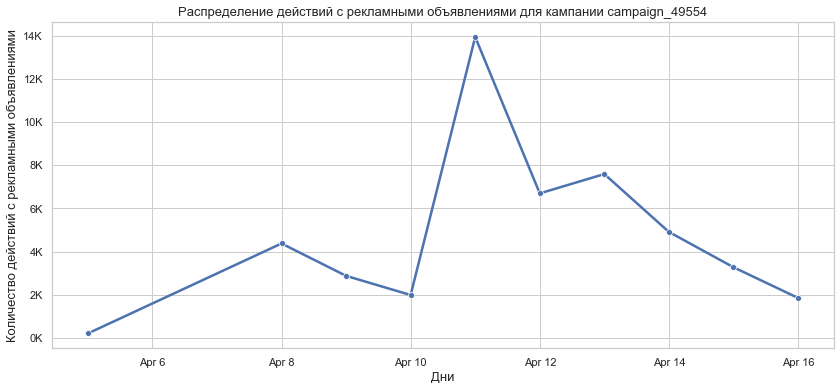

In [16]:
num_events_by_days = wierd_campaign.groupby('date').event.count()

curr_plot = sns.lineplot(style="event", data=num_events_by_days, marker="o", lw=2.5)     
curr_plot.figure.set_size_inches(14, 6)
curr_plot.set_title('Распределение действий с рекламными объявлениями для кампании campaign_49554', fontsize=13)
curr_plot.set_xlabel('Дни', fontsize=13)
curr_plot.set_ylabel('Количество действий с рекламными объявлениями', fontsize=13)

ylabels = ['{:,.0f}'.format(x) + 'K' for x in curr_plot.get_yticks()/1000]
curr_plot.set_yticklabels(ylabels)

curr_plot.xaxis.set_major_formatter(mdates.DateFormatter('%b %#d'))
curr_plot.xaxis.set_major_locator(mdates.DayLocator([x for x in range(32) if x % 2 == 0]) )

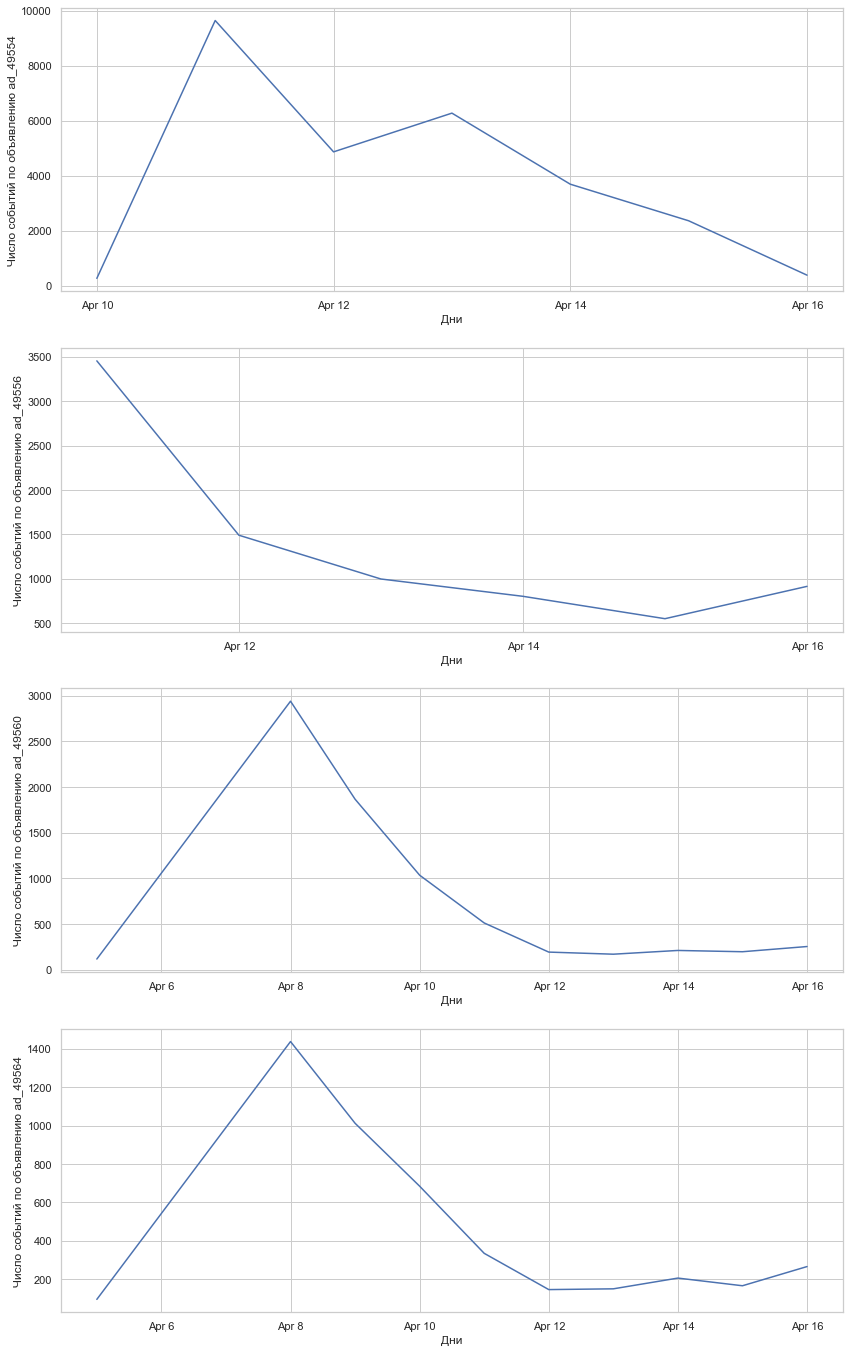

In [17]:
fig, axs = plt.subplots(4)
fig.set_size_inches(14, 24)
for index, adv in enumerate(suspicious_ads[:-1]):
    #plt_data = wierd_campaign[wierd_campaign.ad_id == adv].groupby(['date', col]).agg({'time': 'count'}).reset_index()
    plt_data = wierd_campaign[wierd_campaign.ad_id == adv].groupby('date').event.count()
    curr_plot = sns.lineplot(ax=axs[index], data=plt_data)
    
    curr_plot.set_ylabel("Число событий по объявлению {}".format(adv))
    curr_plot.set_xlabel("Дни")
    curr_plot.xaxis.set_major_formatter(mdates.DateFormatter('%b %#d'))
    curr_plot.xaxis.set_major_locator(mdates.DayLocator([x for x in range(32) if x % 2 == 0]) )

Таким образом мы нашли рекламную кампанию, которая повлияла на рост числа событий 11 апреля. В ней содержатся практически только просмотры, с минимальным количеством кликов и жалоб, при этом все события с оплатой за клики.

Теперь необходимо проверить нет ли дублей в данных. Для этого посмотрим количество одновременных событий в исходном датасете и "проблемной" выборке.

In [18]:
print("Число одновременно произошедших событий в исходном датасете: {}".format(adv_events.time.duplicated().sum()))
print("Число одновременно произошедших событий в выборке: {}".format(wierd_campaign.time.duplicated().sum()))
print("Сотношение размера выборок: {}".format(len(wierd_campaign) / len(adv_events)))
print("Сотношение числа одновременных событий в выборках: {}".format(wierd_campaign.time.duplicated().sum() / adv_events.time.duplicated().sum()))

Число одновременно произошедших событий в исходном датасете: 8308
Число одновременно произошедших событий в выборке: 3207
Сотношение размера выборок: 0.3909924076758643
Сотношение числа одновременных событий в выборках: 0.38601348098218585


Т.к. соотношения размера выборок примерно равно соотношению числа повторяющихся событий, мы можем отвергнуть предположение о том, что "всплеск" вызван повторяющимеся данными.

"Почистим" данные, убрав данные по "проблемной" рекламной кампании и снова построим график.

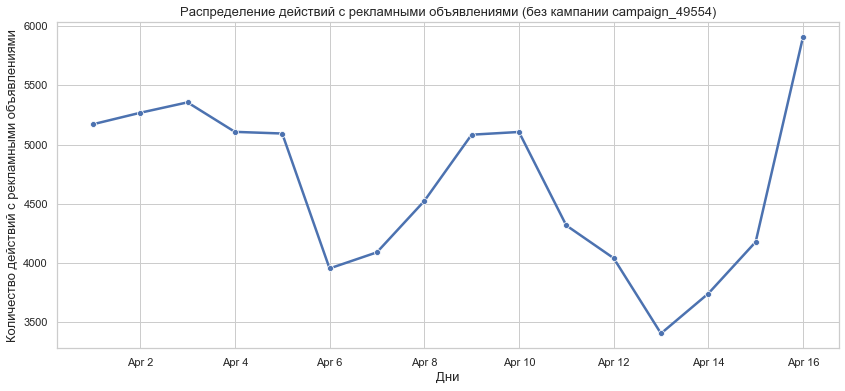

In [19]:
clean_adv = adv_events.query('campaign_union_id != "campaign_49554"')
num_clean_events_by_days = clean_adv.groupby('date').event.count()
curr_plot = sns.lineplot(style="event", data=num_clean_events_by_days, marker="o", lw=2.5)             
curr_plot.figure.set_size_inches(14, 6)
curr_plot.set_title('Распределение действий с рекламными объявлениями (без кампании campaign_49554)', fontsize=13)
curr_plot.set_xlabel('Дни', fontsize=13)
curr_plot.set_ylabel('Количество действий с рекламными объявлениями', fontsize=13)

curr_plot.xaxis.set_major_formatter(mdates.DateFormatter('%b %#d'))
curr_plot.xaxis.set_major_locator(mdates.DayLocator([x for x in range(32) if x % 2 == 0]) )

Данный график отображает картину мира, схожую с реальностью. Существуют значительные просадки в "выходные" дни, но в целом он подчиняется определенному патерну и визуально в нем отсутствуют какие-либо выбросы.

Таким образом мы нашли рекламную кампанию, которая вызвала всплеск количества событий. Дублирования данных не было обнаружено, следовательно, стоит устроить дополнительную проверку данной кампании и рекламного агенства в целом.

Возможно, (если идентификаторы не полный рандом), то агенство agency_2 - это некий служебный аккаунт, на котором производится тестироваание и данные, по которому не должны попадать в датасет.

Или в системе присутствует сбой или уязвимость, позволяющая крутить рекламу без кликов.

Но лучше не гадать, а просто изучить детально агенство, кампанию, клиента и объявление :)

## Часть 3. Автоматический поиск аномалий

Набор данных преобразуется во временной ряд с определенном лагом. Данный временной ряд расскладывается на следующие компоненты (предполагаем адитивную модель разложения):

y(t) = Level + Trend + Seasonality + Noise

В таком случае задачу можно переформулировать как:
1. Разложить ряд на составляющие, исключить уровень, тренд, сезонность.
2. Оценить распределение остатков и найти статистически значимые отклонения, которые и будут выбросами.

Text(0, 0.5, 'Количество действий с рекламными объявлениями')

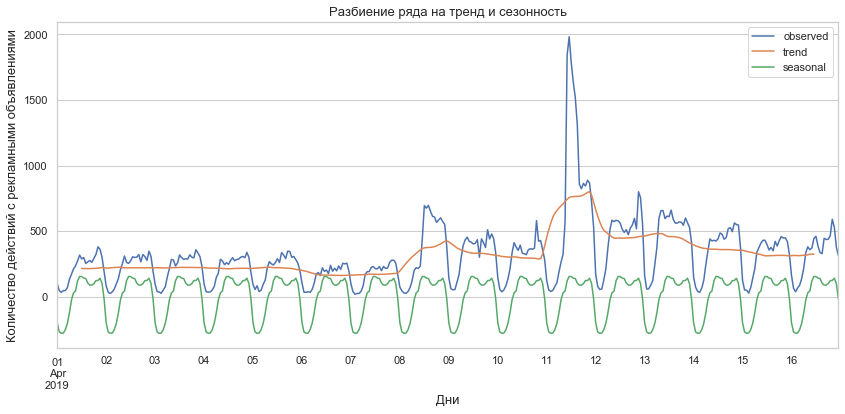

In [20]:
one_hour_sample = adv_events.event.resample('1h').count()
result = seasonal_decompose(one_hour_sample, model='additive')

distib_plot = pd.DataFrame({'observed':result.observed, 'trend':result.trend, 'seasonal':result.seasonal}).plot()
distib_plot.set_title('Разбиение ряда на тренд и сезонность', fontsize=13)
distib_plot.set_xlabel('Дни', fontsize=13)
distib_plot.set_ylabel('Количество действий с рекламными объявлениями', fontsize=13)

Text(0, 0.5, 'Количество действий с рекламными объявлениями')

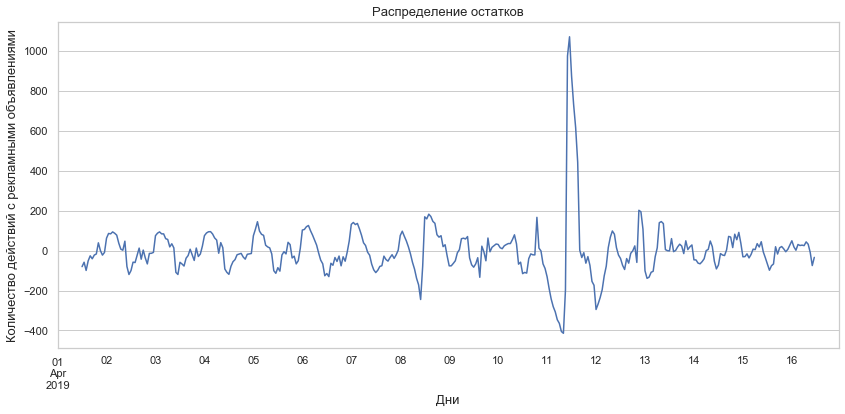

In [21]:
resid_plot = result.resid.plot()
resid_plot.set_title('Распределение остатков', fontsize=13)
resid_plot.set_xlabel('Дни', fontsize=13)
resid_plot.set_ylabel('Количество действий с рекламными объявлениями', fontsize=13)

In [22]:
def AnomalyDetection(df, alpha=0.2):

    # Issue that seasonal_decompose can`t understand freq with 'T' https://github.com/statsmodels/statsmodels/issues/2856
    if ('T' in pd.infer_freq(df.index)):
        result = seasonal_decompose(df, model='additive', freq=288)
    else:
        result = seasonal_decompose(df, model='additive')

    ds = pd.Series(result.resid)
    ds = ds.dropna()

    ares = (ds - ds.mean())/ds.std()
    
    # compute significance
    p = 1. - alpha
    R = stats.expon.interval(p, loc=ares.mean(), scale=ares.std())
    threshold = R[1]
    return ares.index[ares > threshold]

def checkAnomaly(df, period='1h', alpha=0.1):
    df = df.iloc[:,0].resample(period).count()
    r_idx = AnomalyDetection(df, alpha)
    
    plt.plot(df, 'b-')
    plt.plot(r_idx, df.loc[r_idx], 'ro')
    td = pd.Timedelta(period)
    print("Необходимо обратить внимение на следующие временные промежутки:")
    for dt in r_idx:
        print(dt - td, dt)

In [23]:
1 + 1e-12

1.000000000001

С помощью функции checkAnomaly, можно проверить наличие выбросов в выборке, указав произвольный временной лаг в параметре period. Параметр alpha, отвечает за уровень значимости, регулируя его мы может изменять чувствительность функции к выбросам.

#### Примеры использования функции на указанных в условиях периодах:

Необходимо обратить внимение на следующие временные промежутки:
2019-04-11 09:00:00 2019-04-11 10:00:00
2019-04-11 10:00:00 2019-04-11 11:00:00
2019-04-11 11:00:00 2019-04-11 12:00:00
2019-04-11 12:00:00 2019-04-11 13:00:00
2019-04-11 13:00:00 2019-04-11 14:00:00


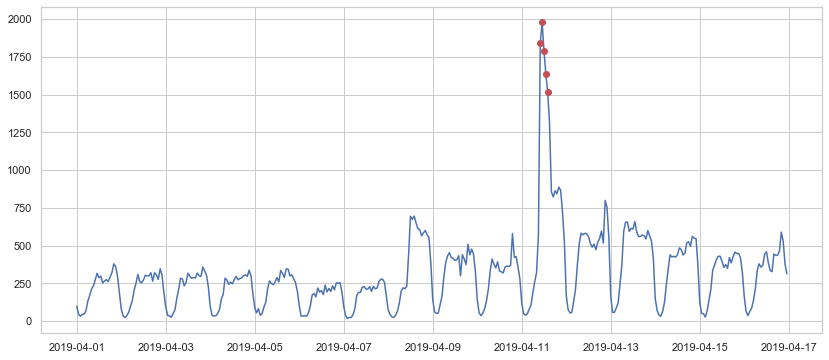

In [24]:
checkAnomaly(adv_events, period='1h', alpha=0.05)

Необходимо обратить внимение на следующие временные промежутки:
2019-04-11 09:50:00 2019-04-11 09:55:00
2019-04-11 10:05:00 2019-04-11 10:10:00
2019-04-11 10:10:00 2019-04-11 10:15:00
2019-04-11 10:30:00 2019-04-11 10:35:00
2019-04-11 10:35:00 2019-04-11 10:40:00
2019-04-11 10:40:00 2019-04-11 10:45:00
2019-04-11 10:45:00 2019-04-11 10:50:00
2019-04-11 10:50:00 2019-04-11 10:55:00
2019-04-11 10:55:00 2019-04-11 11:00:00
2019-04-11 11:00:00 2019-04-11 11:05:00
2019-04-11 11:05:00 2019-04-11 11:10:00
2019-04-11 11:10:00 2019-04-11 11:15:00
2019-04-11 11:15:00 2019-04-11 11:20:00
2019-04-11 11:20:00 2019-04-11 11:25:00
2019-04-11 11:25:00 2019-04-11 11:30:00
2019-04-11 11:30:00 2019-04-11 11:35:00
2019-04-11 11:40:00 2019-04-11 11:45:00
2019-04-11 11:50:00 2019-04-11 11:55:00
2019-04-11 12:00:00 2019-04-11 12:05:00
2019-04-11 12:15:00 2019-04-11 12:20:00
2019-04-11 12:20:00 2019-04-11 12:25:00
2019-04-11 12:25:00 2019-04-11 12:30:00
2019-04-11 12:30:00 2019-04-11 12:35:00
2019-04-11 12:35

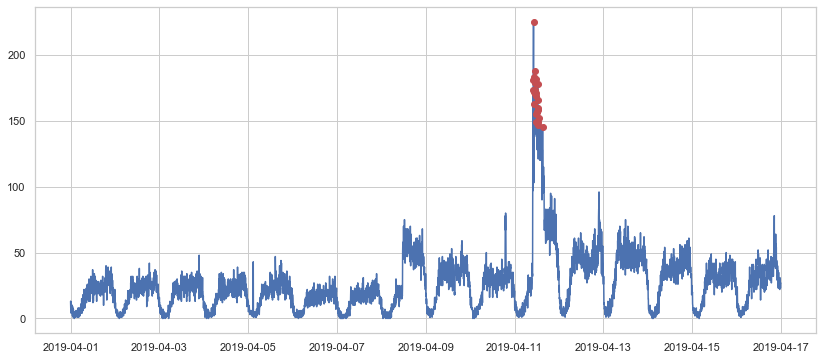

In [25]:
checkAnomaly(adv_events, period='5min', alpha=0.01)